# Datenvorbereitung
Im diesem Notebook werden die Traingsdaten aus dem Datenset [CULane](https://xingangpan.github.io/projects/CULane.html) (driver_23_30frame.tar.gz) eingelesen und so verarbeitet, dass sie an ein Deep Learning Modell übergeben werden können.  
Ziel ist es dabei ein Modell zu schaffen, anhand dessen ein Fahrzeug zuverlässig auf der Rechten Fahrspur fahren kann.

## Trainingsdaten und Labels:
Die Trainingsdaten liegen in Form von Bildern vor, die Labels in Form von txt files.
Eine zeile im Labels txt file beschreibt eine Fahrbahnlinie. Hierbei sind immer Abwechsungsweise X und Y Koordinaten aneinandergereit. In Zweierpaaren ergeben diese die Linien.


**Bilder:** 
---
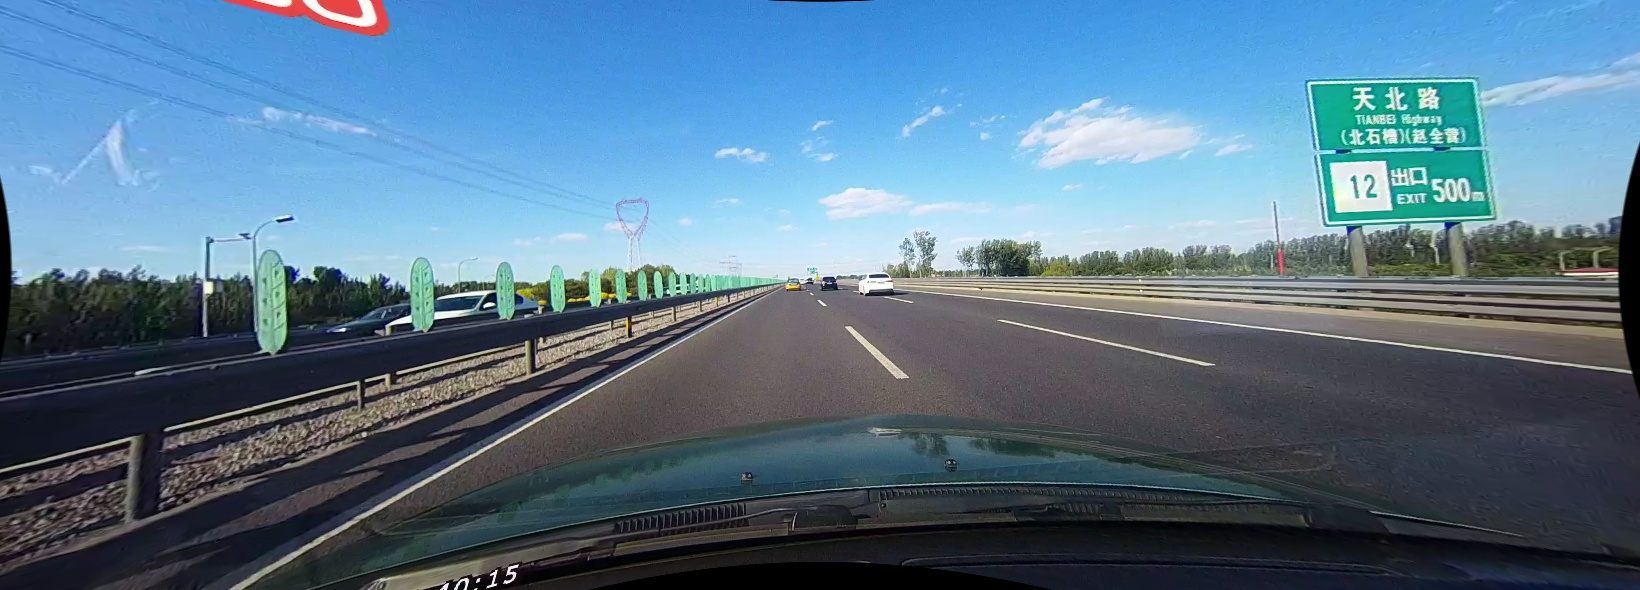
---
**Labels**:
---
-16.9803 490 21.2945 480 60.0118 470 98.729 460 137.446 450 175.196 440 213.913 430 252.63 420 291.347 410 330.065 400 368.782 390 406.814 380 445.531 370 484.248 360 521.998 350 560.715 340 599.432 330 638.149 320 676.867 310 714.616 300 753.333 290   
267.511 590 284.513 580 301.739 570 318.104 560 335.33 550 352.556 540 368.921 530 386.147 520 403.374 510 419.739 500 436.965 490 454.191 480 470.556 470 487.782 460 505.008 450 521.373 440 539.159 430 555.524 420 572.75 410 589.976 400 606.341 390 623.568 380 640.794 370 657.159 360 674.385 350 691.611 340 707.976 330 725.202 320 742.428 310 758.793 300 776.02 290   
1197.91 590 1185.25 580 1171.77 570 1159.08 560 1145.6 550 1132.91 540 1119.43 530 1106.74 520 1094.05 510 1080.56 500 1067.87 490 1054.39 480 1041.7 470 1029.01 460 1015.53 450 1002.84 440 989.531 430 976.842 420 963.359 410 950.669 400 937.187 390 924.497 380 911.808 370 898.325 360 885.636 350 872.153 340 859.464 330 845.981 320 833.292 310 820.602 300 807.119 290   
1649.3 450 1598.81 440 1548.79 430 1498.77 420 1448.76 410 1398.74 400 1347.74 390 1297.72 380 1247.71 370 1197.5 360 1147.49 350 1097.47 340 1046.47 330 996.453 320 946.435 310 896.418 300 846.4 290 
---

Die Labels weißen unterschiedliche Längen auf. In diesem Beispiel fängt Linie 1 bei 490 an und geht bis 290, Linie 4 hingegen fängt erst bei 450 an. Um ein einheitliches Labelformat zu bekommen sollen die Label zu einer Matrix verarbeitet werden. Diese soll möglichst klein ausfallen damit Rechenleistung gespart werden kann. Hierfür stehen verschiedene Ansätze bereit:

## Ansatz 1:
Es wird ein Array erzeugt und darin alle Linien markiert:
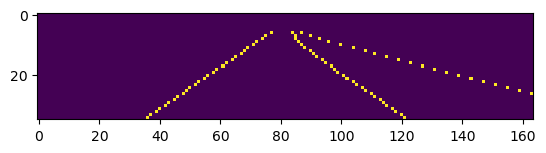

## Ansatz 2: 
Es wird ein Array erzeugt und alle Linien mit unterschiedlichen Werten markiert
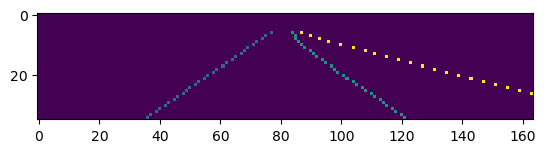

## Ansatz 3:
Es wird ein Array erzeugt und die Mitte der rechten Spur wird mit einer Linie markiert.
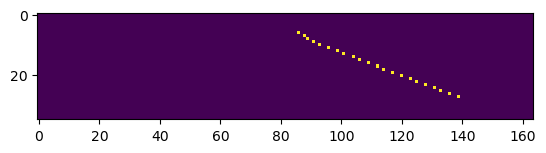

In [13]:
#hier Ansatz  auswählen, wie die Daten verarbeitet werden sollen:
ansatz= 2 # 1, 2, 3
#hier Name auswählen unter dem die Daten gespeichert werden sollen:
lable_name = "ansatz1new"


## Bibliotheken laden:

In [1]:
import numpy as np #performante Bibliothek zur Array Verwaltung
import cv2 #Bibliothek zur Bildbearbeitung
import matplotlib.pyplot as plt #Bibliothek zum plotten von Bildern im Notebook
import os # Bibliothek zur Verwaltung von Dateiordnern
import re #Bibliothek zur verwendung von Regular Expressions
from tqdm import tqdm #Bibliothek zur Anzeige eines Fortschrittbalkens
import skimage.measure # Bibliothek zur Bildverarbeitung

## Trainingsdaten Importieren:
Es werden alle Unterordner des Verzeichnisses Datensaetze durchsucht und die Namen der Bilder und txt files in die beiden Listen img_paths und txt_paths geschrieben.

In [2]:
#Leere Listen für die Pfade der Bilder und Text files erstellen:
img_paths= []
txt_paths= []
#den Ordner mit den Datensätzen nach allen Dateien durchsuchen und diese in die zwei Listen einordnen:
for path, currentDirectory, files in os.walk("C:/Users/boby1/Documents/Omniwheels/Datensaetze_gesamt"):#(".\Datensaetze"):
    for file in files:
        #aus dem Dateipfad und dem Dateinamen einen relativen Dateipfad zusammensetzen:
        full_path=os.path.join(path,file)
        #Die Dateipfade nach Bilder (endet mit .jpg) und Text (endet mit .txt) sortieren und in die vorgesehene Liste eintragen:
        if re.search('jpg\Z',file):
        #if file contains jpg ->
            img_paths.append(full_path)
        elif re.search('txt\Z',file):
            if img_paths:
                if (img_paths[-1][:-4]==full_path[:-10]):
                    txt_paths.append(full_path)
                else: 
                    print("Warning:"+img_paths[-1] +"!="+full_path)
        else:
            print("Warning: unidentified string: "+full_path)
if not len(img_paths)==len(txt_paths):
    raise SystemExit("Error: different numbers of images and labels")



Als nächstes wird ein Bild eingelesen um die Richtigkeit der Dateipfade zu überprüfen

In [4]:
test = cv2.imread(img_paths[0],0)
test=np.array(test)
test.shape

(590, 1640)

Skalierungsgröße der Daten manuell einstellen:

In [15]:
scale_percent = 10

Anschließend werden alle Bilder in img_paths eingelesen und auf die gewünschte Größe verkleinert.   
Methode nur anwenden, wenn andere Größe als 10% oder 15% gewünscht sein sollte. Name der Datei evtl. abändern.   
**!!!Achtung das Ausführen dieser Zelle kann extrem lange dauern!!**  
  **Laden einer bereits verfügbaren npy Datei bevorzugen**  
  (es kann aufgrund der Komprimierung durch Gitlab dazu kommen, dass Dateien nicht einlesbar sind, hier ist das neu einlesen nicht zu vermeiden, in diesem Fall [driver_23_30frame.tar.gz] (https://drive.google.com/drive/folders/1mSLgwVTiaUMAb4AVOWwlCD5JcWdrwpvu)herunterladen, entpacken und mit dem folgenden Bock einlesen)

In [3]:
width = 320# int(test.shape[1] * scale_percent / 100)
height = 240#int(test.shape[0] * scale_percent / 100)
dim = (width, height)
"""
#f= IntProgress(min=0, max=max_count)
#display(f)
#save every 100pictures:
savenum=0
counter=0
saveevery=100
imgs=np.empty([0,height, width]) #leeres numpy array für Bilder erstellen
for path in tqdm(img_paths): #tqdm zeigt Fortschritt an
    resized_img = cv2.resize(cv2.imread(path,0), dim) #  die 0 in cv2.imread steht für schwarz-weiß einlesen
    imgs= np.append(imgs,[resized_img],axis=0) 
    counter=counter+1
    if counter >=saveevery:
        name= "./data_part/Data320x240fullSet" +str(savenum)
        np.save(name, imgs)
        imgs=np.empty([0,height, width]) #array leeren
        savenum =savenum+1
        counter =0
name= "./data_part/Data320x240fullSet" +str(savenum)
np.save(name, imgs)
print("counter"+str(counter) + " savenum" + str(savenum))
#np.save("Data320x240fullSet", imgs)"""


'\n#f= IntProgress(min=0, max=max_count)\n#display(f)\n#save every 100pictures:\nsavenum=0\ncounter=0\nsaveevery=100\nimgs=np.empty([0,height, width]) #leeres numpy array für Bilder erstellen\nfor path in tqdm(img_paths): #tqdm zeigt Fortschritt an\n    resized_img = cv2.resize(cv2.imread(path,0), dim) #  die 0 in cv2.imread steht für schwarz-weiß einlesen\n    imgs= np.append(imgs,[resized_img],axis=0) \n    counter=counter+1\n    if counter >=saveevery:\n        name= "./data_part/Data320x240fullSet" +str(savenum)\n        np.save(name, imgs)\n        imgs=np.empty([0,height, width]) #array leeren\n        savenum =savenum+1\n        counter =0\nname= "./data_part/Data320x240fullSet" +str(savenum)\nnp.save(name, imgs)\nprint("counter"+str(counter) + " savenum" + str(savenum))\n#np.save("Data320x240fullSet", imgs)'

In [7]:
"""imgsfull=np.empty([0,height, width])
savenum=0
for paths, currentDirectory, files in tqdm(os.walk("./data_part/")):#(".\Datensaetze"):
    for num,file in enumerate(files):
        name=("Data320x240fullSet"+str(num)+".npy")
        print(name)
        #aus dem Dateipfad und dem Dateinamen einen relativen Dateipfad zusammensetzen:
        full_path=os.path.join(paths,name)
        print(full_path)
        imgs =np.load(full_path,allow_pickle=True)
        print(imgs.shape)
        print(imgsfull.shape)
        imgsfull= np.append(imgsfull,imgs,axis=0)
        if ((num+1)%50==0):
            name="./data_part_bigger/Data320x240fullSet"+str(savenum)
            np.save(name, imgsfull)
            savenum=savenum+1
            imgsfull=np.empty([0,height, width])

name="./data_part_bigger/Data320x240fullSet"+str(savenum)
np.save(name, imgsfull)"""

'imgsfull=np.empty([0,height, width])\nsavenum=0\nfor paths, currentDirectory, files in tqdm(os.walk("./data_part/")):#(".\\Datensaetze"):\n    for num,file in enumerate(files):\n        name=("Data320x240fullSet"+str(num)+".npy")\n        print(name)\n        #aus dem Dateipfad und dem Dateinamen einen relativen Dateipfad zusammensetzen:\n        full_path=os.path.join(paths,name)\n        print(full_path)\n        imgs =np.load(full_path,allow_pickle=True)\n        print(imgs.shape)\n        print(imgsfull.shape)\n        imgsfull= np.append(imgsfull,imgs,axis=0)\n        if ((num+1)%50==0):\n            name="./data_part_bigger/Data320x240fullSet"+str(savenum)\n            np.save(name, imgsfull)\n            savenum=savenum+1\n            imgsfull=np.empty([0,height, width])\n\nname="./data_part_bigger/Data320x240fullSet"+str(savenum)\nnp.save(name, imgsfull)'

In [8]:
"""imgsfull=np.empty([0,height, width])
savenum=0
for paths, currentDirectory, files in tqdm(os.walk("./data_part_bigger/")):#(".\Datensaetze"):
    for num,file in enumerate(files):
        name=("Data320x240fullSet"+str(num)+".npy")
        print(name)
        #aus dem Dateipfad und dem Dateinamen einen relativen Dateipfad zusammensetzen:
        full_path=os.path.join(paths,name)
        print(full_path)
        imgs =np.load(full_path,allow_pickle=True)
        print(imgs.shape)
        print(imgsfull.shape)
        imgsfull= np.append(imgsfull,imgs,axis=0)

name="./data_full_set/Data320x240fullSet"
np.savez_compressed(name, X= imgsfull)
"""

'imgsfull=np.empty([0,height, width])\nsavenum=0\nfor paths, currentDirectory, files in tqdm(os.walk("./data_part_bigger/")):#(".\\Datensaetze"):\n    for num,file in enumerate(files):\n        name=("Data320x240fullSet"+str(num)+".npy")\n        print(name)\n        #aus dem Dateipfad und dem Dateinamen einen relativen Dateipfad zusammensetzen:\n        full_path=os.path.join(paths,name)\n        print(full_path)\n        imgs =np.load(full_path,allow_pickle=True)\n        print(imgs.shape)\n        print(imgsfull.shape)\n        imgsfull= np.append(imgsfull,imgs,axis=0)\n\nname="./data_full_set/Data320x240fullSet"\nnp.savez_compressed(name, X= imgsfull)\n'

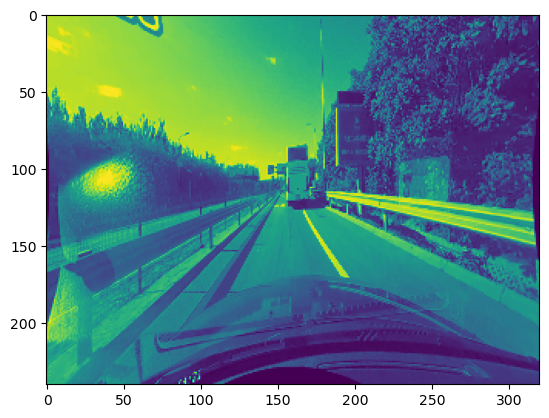

In [4]:
imgs =np.load("./data_full_set/Data320x240fullSet.npz")['X'] # laden der Bilder
#imgs =np.load("C:/Users/boby1/Documents/Omniwheels/Data10percCompressed.npy")
plt.imshow(imgs[245])

In [10]:
#imgs = np.append(imgs, imgsnew)
#lables= numpy.append(lables, lablesnew)
#np.savez_compressed("./data_compressed/allData10percCompressed", imgs= imgs)

## Trainingsdaten verarbeiten:
Bilder normalisieren

In [5]:
imgs=imgs/255

Da die Label in unterschiedlich langen Zeilen stehe, kann für das einlesen der einzelnen Zeilen kein numpy array genutzt werden. Die Zeilen werden hier in eine Liste eingelesen und diese in ein numpy array geschrieben:

In [6]:
lane=[]
for lane_path in txt_paths:
    lanes= open(lane_path)
    lane.append(np.array([np.array(lanes.readline().split()),np.array(lanes.readline().split()),np.array(lanes.readline().split()),np.array(lanes.readline().split())]))
lane[0]

C:\Users\boby1\AppData\Local\Temp\ipykernel_4712\1051400732.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  lane.append(np.array([np.array(lanes.readline().split()),np.array(lanes.readline().split()),np.array(lanes.readline().split()),np.array(lanes.readline().split())]))


array([array(['240.573', '590', '257.848', '580', '275.127', '570', '292.409',
              '560', '309.699', '550', '327.126', '540', '344.433', '530',
              '361.753', '520', '379.085', '510', '396.56', '500', '413.925',
              '490', '431.309', '480', '448.714', '470', '467.012', '460',
              '484.586', '450', '502.935', '440', '520.431', '430', '538.821',
              '420', '557.229', '410', '575.653', '400', '593.868', '390',
              '612.315', '380', '630.77', '370', '649.232', '360', '667.698',
              '350', '686.165', '340', '704.416', '330', '722.879', '320',
              '741.337', '310', '759.788', '300', '778.228', '290'], dtype='<U7'),
       array(['1146.04', '590', '1133.33', '580', '1120.99', '570', '1108.67',
              '560', '1097.02', '550', '1084.72', '540', '1073.22', '530',
              '1060.98', '520', '1049.07', '510', '1037.67', '500', '1025.92',
              '490', '1014.6', '480', '1003.34', '470', '992.112', '46

Im nächsten Schritt werden die X und Y Werte getrennt und in zwei Array gesschrieben.   
Die X und Y Werte mit dem selben Index gehören dabei jeweils zusammen.

In [7]:
xlane_array =[]
ylane_array =[]
picture_number=0
lane_number=0
value_number=0
for picture in lane:
    ylane =[[],[],[],[]] 
    xlane =[[],[],[],[]]
    for number in picture:
    
        for pixel in number:
            if value_number %2:
                ylane[lane_number].append(float(pixel))
                value_number +=1
            else:
                xlane[lane_number].append(float(pixel))
                value_number+=1
        lane_number+=1
    lane_number=0
    xlane_array.append(xlane)
    ylane_array.append(ylane)
    picture_number+=1

Wie auf dem Beispielbild (am Anfang des Notebooks) zu sehen, enthältder obere Teil des Bildes keine Straße und somit keine für das Modell nützliche Informationen. Daher wird der Obere Teil der Bilder abgetrennt. Die Variable top_pixel entscheidet hierbei an welcher Stelle. Der Wert von top_pixel ist hierbei im Bezug auf die Originale Bildgröße (590x1640) anzugeben. 

In [8]:
top_pixel=230 # in originalgröße
yscale = 240/590
xscale=320/1640
top_pixel_scaled=int(230*yscale)

Da das Fahrzeug auf einer Straße mit zwei Fahrspuren fahren soll, werden alle Daten, die mehr oder weniger als zwei spuren enthalten aussortiert. Die Anzahl der Bilder mit zwei Spuren wurde anhand der variable two_lane_pics herausgefunden.

In [9]:
#todo: statt fester deklaration deklaration mit 0,59,164 und append
numberof2lanepics = 0
for pic_num, picture in enumerate(xlane_array):
    #überprüfe ob das Bild 2 Spuren hat (also 3 Fahrstreifen (0,1,2))
    if picture[2] and not picture[3]: #leere Listen geben in einer if Bedingung einen False wert zurück
        numberof2lanepics+=1

In [10]:
lable =np.zeros((numberof2lanepics,35, 164),dtype= float) # creating array of zeros for every possible pixel of a lane
lable.shape

(55312, 35, 164)

In [11]:
#getting pics with 2 lanes (number taken from two_lanes pics in next section)
pics_2lanes= np.zeros((numberof2lanepics,imgs.shape[1], imgs.shape[2]),dtype= np.float64)

Abschneiden des oberen Teil des Bildes und neubildung der Labels nach den oben beschriebenen Ansätzen:

In [16]:
two_lane_pics=0
right_lane=4 #initialisierungswert unerreichtbar -> führt bei nichtüberschreiben zu Fehler
middle_lane=4#initialisierungswert unerreichtbar -> führt bei nichtüberschreiben zu Fehler
for pic_num, picture in enumerate(xlane_array):
    #überprüfe ob das Bild 2 Spuren hat (also 3 Fahrstreifen (0,1,2))
    if picture[2] and not picture[3]: #leere Listen geben in einer if Bedingung einen False wert zurück
        right_lane=2
        middle_lane=1
        left_lane=0
        pics_2lanes[two_lane_pics]=imgs[pic_num]
        
        #löschen aller Labeldaten oberhalb ( im default: alle werte unterhalb von 230) des top_pixel (Labels sind nicht gescaled)
        for lane_num, lane in enumerate(ylane_array[pic_num]):
            for pixel_num, pixel in enumerate(lane): 
                if pixel <= top_pixel: #durchsucht Label eines Bilds nach Pixeln unter top_pixel (im Bild überhalb des festgelegten schwellwerts)
                    y= ylane_array[pic_num][lane_num]
                    del y[:pixel_num-1]
                    ylane_array[pic_num][lane_num] =y
                    x= xlane_array[pic_num][lane_num]
                    del x[:pixel_num-1]
                    xlane_array[pic_num][lane_num]=x
                    break #sobald die Pixel in einem Bild gelöscht wurden, wird das nächste bearbeitet
            #Einzeichnen der Linien in das Label Array
            for pixel_num, pixel in enumerate(lane):
                #try except wird benötigt, da es einige Koordinaten außerhalb des Bildes gibt (im negativen oder höher als der Bildrand)
                try:
                    if ansatz== 1:
                        #weißt jedem Wert alle Linien eine 1 zu
                        lable[two_lane_pics][int(pixel*scale_percent/100)-23][int(xlane_array[pic_num][lane_num][pixel_num]*scale_percent/100)]=1
                    elif ansatz==2:
                        #weißt jedem Wert einer Linie einen der Linie zugeordneten Wert zu:
                        #rechte Linie:1
                        #mittlere Linie: 0.5
                        #linke Linie: 0.333
                        lable[two_lane_pics][int(pixel*scale_percent/100)-23][int(xlane_array[pic_num][lane_num][pixel_num]*scale_percent/100)]=1/(3-lane_num)
                except IndexError:
                    continue
            if ansatz ==3:
                #weißt der Mitte der Rechten Spur eine 1 zu
                #um möglichst weit unten mit der Mittelwertbildung anzufangen wird das Array von unten nach oben eingelesen
                for pixel_num, pixel in enumerate(reversed(picture[right_lane])):
                    try:
                        #Um den nidrigsten möglichen Mittelwert zu bekommen,
                        #werden die beiden untersten Werte der rechten und Mittelinie als startpunkt genommen. 
                        #Von da an werden beide immer um eins erhöht
                        x_avg= int((pixel+xlane_array[pic_num][middle_lane][-1*(pixel_num+1)])/2*scale_percent/100)
                        y_avg= int((ylane_array[pic_num][right_lane][-1*(pixel_num+1)]+ylane_array[pic_num][middle_lane][-1*(pixel_num+1)])/2*scale_percent/100)
                        #Zeichne die Mittelwerte in die Labels ein
                        lable[two_lane_pics][int(y_avg)-23][int(x_avg)]=1
                    except IndexError:
                        continue
        
        two_lane_pics+=1           

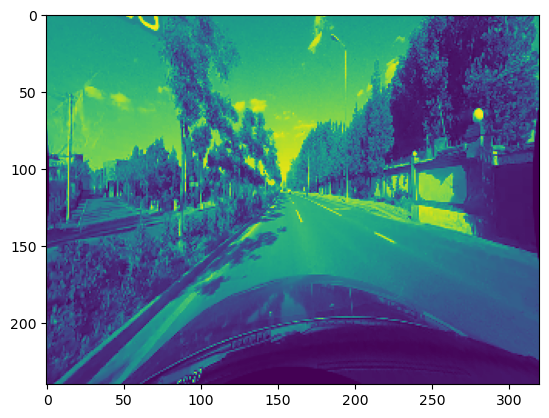

In [18]:
plt.imshow(pics_2lanes[245])

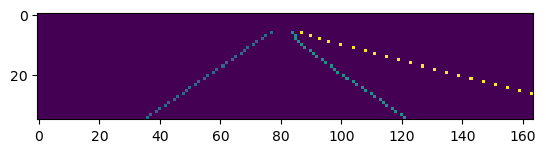

In [17]:
plt.imshow(lable[200])

Verkleinern der Label durch max-pooling (Datengröße schrumpft, wichtige Informationen bleiben erhalten):

In [28]:
label_resized=np.zeros((numberof2lanepics,9,21),dtype=float)
for number, img in enumerate(lable):
    label_resized[number]=skimage.measure.block_reduce(img, block_size=(4,8), func=np.max)

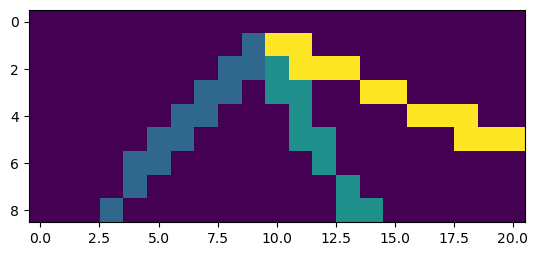

In [29]:
plt.imshow(label_resized[0])

Bilddaten um eine Dimension erweitern und alles überhalb des top_pixels abschneiden

In [19]:
imgs= pics_2lanes[..., np.newaxis] 
cut_imgs= np.zeros((numberof2lanepics,height-top_pixel_scaled,width,1),dtype= float)
for img_number, image in enumerate(imgs):
    cut_imgs[img_number]=image[top_pixel_scaled :]

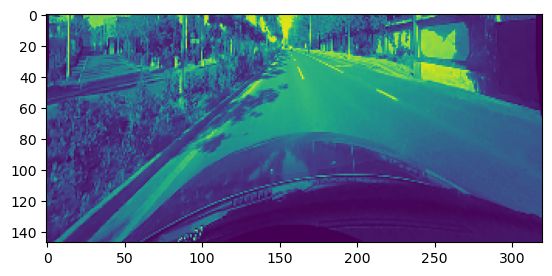

In [20]:
del imgs 
del pics_2lanes
plt.imshow(cut_imgs[245])

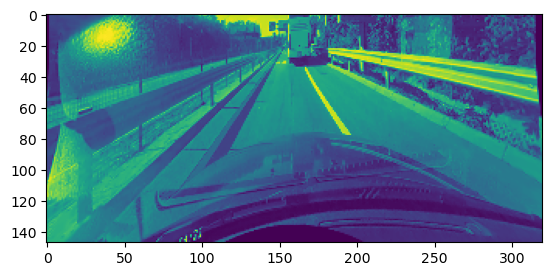

In [21]:
plt.imshow(cut_imgs[200])

Label flatten

In [33]:
len(label_resized)

55312

In [34]:
label_resized = label_resized.reshape(numberof2lanepics,189)

Label und Bilder Speichern (zum Upload auf gitlab bitte npz fromat nutzen, da npy Format durch komprimierung beschädigt wird)

In [ ]:
#all_pictures = np.append(np.load("C:/Users/boby1/Documents/txt4.0-omniwheels-lane-detection/CNN_Modell/processed_imgs/10perc.npz")["imgs"],cut_imgs,axis=0)
#all_labels= np.append(np.load("C:/Users/boby1/Documents/txt4.0-omniwheels-lane-detection/CNN_Modell/label/ansatz1.npz")["imgs"],label_resized,axis=0)


In [ ]:
#tset=np.load("C:/Users/boby1/Documents/txt4.0-omniwheels-lane-detection/CNN_Modell/processed_imgs/10perc.npz")["imgs"]
#len(all_pictures)

93805

In [ ]:
#len(all_labels[1])

189

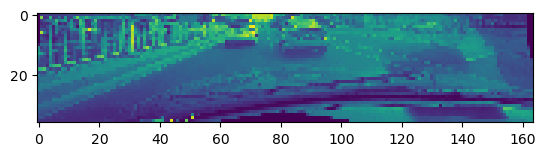

In [ ]:
#plt.imshow(all_pictures[90000])

In [35]:
#np.save("./label/ansatz1",label_resized)
#np.savez_compressed("./label/ansatz2complete", imgs= lable)
#np.save("./processed_imgs/10perc",cut_imgs)
#np.load("")
np.savez_compressed("./processed_imgs/camfullsized_lable1_complete", imgs= cut_imgs, lable= label_resized)

In [36]:
np.where(label_resized == 0)

(array([    0,     0,     0, ..., 55311, 55311, 55311], dtype=int64),
 array([  0,   1,   2, ..., 186, 187, 188], dtype=int64))